# 爬取拉勾热门职位分析

## 任务说明

这一周，你的任务是从拉勾网上，选择自己最感兴趣的职位，获取相关数据并进行分析： 
- 这个岗位的薪酬情况是怎样的？ 
- 企业对该岗位的工作经验、学历要求是怎样的？ 
- 目前招募该岗位的都是哪些类型的企业？（融资阶段、公司规模、行业领域）

# 数据准备

In [498]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['simhei']

In [499]:
# 我爬取的数据是拉勾网上广州地区的数据挖掘岗位
lagou = pd.read_csv('lagou_gz.csv')

In [500]:
lagou.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 9 columns):
title           282 non-null object
district        282 non-null object
company         282 non-null object
salary_min      282 non-null int64
salary_max      282 non-null int64
demand          282 non-null object
company_info    282 non-null object
tag             282 non-null object
comment         282 non-null object
dtypes: int64(2), object(7)
memory usage: 19.9+ KB


- 数值型变量只有salary_min和salary_max两个
- 其他都是字符变量

In [501]:
lagou.head()

,title,district,company,salary_min,salary_max,demand,company_info,tag,comment
0,算法工程师(J10259),珠江新城,趣丸,25,50,\n经验不限/硕士,游戏 / 不需要融资 / 500-2000人,社交\n ...,"“大牛多,平台大,福利好,高薪”"
1,2021校园招聘-算法工程师-GZ,冼村,深演智能,15,25,\n经验在校/应届/硕士,人工智能服务 / D轮及以上 / 150-500人,广告营销\n ...,“技术氛围好；平台好；公司发展快”
2,深度学习算法工程师,天河区,深声科技,15,30,\n经验不限/本科,人工智能服务 / 天使轮 / 50-150人,深度学习,"“弹性工作,上班不打卡,五险一金,有餐补”"
3,算法工程师（图像配准）,广州大道南,柏视医疗,15,30,\n经验不限/硕士,"医疗丨健康,数据服务 / A轮 / 50-150人",医疗健康\n ...,“团队实力强”
4,高级推荐算法工程师 (MJ003526),番禺区,欢聚集团（JOYY Inc.）,30,60,\n经验不限/本科,"社交媒体,MCN｜直播平台 / 上市公司 / 2000人以上",C++\n ...,“健身房；餐补；免费咖啡”


- 用web scraper爬取数据后，用excel做了一些简单的数据处理
- 但还存在一些问题，后面还要进行数据清洗
- demand列存在\n，要去掉
- demand可以切分为experience,qualification分别表示经验要求，学历要求
- tag的\n用、替换
- comment的双引号也要去掉
- company_info可以切分为domain,finance,scale分别表示公司所在领域，融资情况，公司规模

In [502]:
lagou.describe()

,salary_min,salary_max
count,282.000000,282.000000
mean,18.872340,33.308511
std,7.900945,13.077127
min,3.000000,6.000000
25%,15.000000,25.000000
50%,19.500000,30.000000
75%,25.000000,40.000000
max,60.000000,70.000000


## 数据清洗

### demand的清洗（去掉\n，切分）

In [503]:
lagou[['demand', 'tag']].head()

,demand,tag
0,\n经验不限/硕士,社交\n ...
1,\n经验在校/应届/硕士,广告营销\n ...
2,\n经验不限/本科,深度学习
3,\n经验不限/硕士,医疗健康\n ...
4,\n经验不限/本科,C++\n ...


- 去掉demand的\n
- 用、替换tag的\n

In [504]:
lagou['demand'] = lagou['demand'].str.replace('\n','')
lagou['demand'].head()

0       经验不限/硕士
1    经验在校/应届/硕士
2       经验不限/本科
3       经验不限/硕士
4       经验不限/本科
Name: demand, dtype: object

- 接下来做一个切分
    - experience
    - recent
    - qualification

In [505]:
split_list = lagou['demand'].str.split('/')
split_list

0          [经验不限, 硕士]
1      [经验在校, 应届, 硕士]
2          [经验不限, 本科]
3          [经验不限, 硕士]
4          [经验不限, 本科]
5          [经验不限, 本科]
6          [经验不限, 本科]
7          [经验不限, 本科]
8      [经验在校, 应届, 硕士]
9          [经验不限, 硕士]
10         [经验不限, 本科]
11         [经验不限, 硕士]
12         [经验不限, 硕士]
13         [经验不限, 硕士]
14         [经验不限, 本科]
15       [经验1-3年, 本科]
16       [经验1-3年, 硕士]
17       [经验3-5年, 本科]
18       [经验3-5年, 本科]
19       [经验1-3年, 本科]
20       [经验3-5年, 本科]
21       [经验1-3年, 硕士]
22      [经验5-10年, 本科]
23      [经验5-10年, 本科]
24       [经验1-3年, 本科]
25       [经验3-5年, 本科]
26     [经验在校, 应届, 本科]
27       [经验3-5年, 本科]
28       [经验3-5年, 本科]
29       [经验3-5年, 本科]
            ...      
252      [经验1-3年, 硕士]
253      [经验3-5年, 本科]
254      [经验1-3年, 硕士]
255      [经验3-5年, 本科]
256      [经验3-5年, 本科]
257      [经验1-3年, 本科]
258      [经验3-5年, 本科]
259      [经验3-5年, 本科]
260    [经验在校, 应届, 硕士]
261      [经验3-5年, 本科]
262      [经验3-5年, 本科]
263    [经验在校, 应届, 硕士]
264    [经验在校, 应届, 本科]
265      [经验3-5年, 本科]
266      [

- 可以看到有些分为了2个元素，有些分为了3个元素
- 所有3个元素的都是有应届，经验在校即表示应届身份，因此可以去掉应届，只保留经验在校

In [506]:
demand = []
qualification = []
for i in range(len(split_list)):
    demand.append(split_list[i][0])
    qualification.append(split_list[i][-1])

In [507]:
lagou['experience'] = demand
lagou['qualification'] = qualification
lagou = lagou.drop(['demand'], axis=1)

In [508]:
lagou.head()

,title,district,company,salary_min,salary_max,company_info,tag,comment,experience,qualification
0,算法工程师(J10259),珠江新城,趣丸,25,50,游戏 / 不需要融资 / 500-2000人,社交\n ...,"“大牛多,平台大,福利好,高薪”",经验不限,硕士
1,2021校园招聘-算法工程师-GZ,冼村,深演智能,15,25,人工智能服务 / D轮及以上 / 150-500人,广告营销\n ...,“技术氛围好；平台好；公司发展快”,经验在校,硕士
2,深度学习算法工程师,天河区,深声科技,15,30,人工智能服务 / 天使轮 / 50-150人,深度学习,"“弹性工作,上班不打卡,五险一金,有餐补”",经验不限,本科
3,算法工程师（图像配准）,广州大道南,柏视医疗,15,30,"医疗丨健康,数据服务 / A轮 / 50-150人",医疗健康\n ...,“团队实力强”,经验不限,硕士
4,高级推荐算法工程师 (MJ003526),番禺区,欢聚集团（JOYY Inc.）,30,60,"社交媒体,MCN｜直播平台 / 上市公司 / 2000人以上",C++\n ...,“健身房；餐补；免费咖啡”,经验不限,本科


### 替换tag的\n

In [509]:
lagou['tag'] = lagou['tag'].str.replace('\n', '、')
lagou['tag'] = lagou['tag'].str.replace(' ', '')
lagou['tag'].head()

0                         社交、推荐算法
1                   广告营销、大数据、数仓建模
2                            深度学习
3    医疗健康、医学图像配准、CUDA编程、GPU加速、多模态
4            C++、Python、Java、推荐算法
Name: tag, dtype: object

### 去掉comment的双引号

In [510]:
lagou['comment'] = lagou['comment'].str.replace('“','')
lagou['comment'] = lagou['comment'].str.replace('”','')
lagou['comment'].head()

0         大牛多,平台大,福利好,高薪
1        技术氛围好；平台好；公司发展快
2    弹性工作,上班不打卡,五险一金,有餐补
3                  团队实力强
4            健身房；餐补；免费咖啡
Name: comment, dtype: object

### 切分company_info

In [511]:
lagou['company_info'] = lagou['company_info'].str.replace(' ', '')
split_list = lagou['company_info'].str.split('/')
split_list

0                        [游戏, 不需要融资, 500-2000人]
1                     [人工智能服务, D轮及以上, 150-500人]
2                        [人工智能服务, 天使轮, 50-150人]
3                     [医疗丨健康,数据服务, A轮, 50-150人]
4                [社交媒体,MCN｜直播平台, 上市公司, 2000人以上]
5                    [内容资讯,短视频, D轮及以上, 2000人以上]
6                [社交媒体,MCN｜直播平台, 上市公司, 2000人以上]
7                       [工具类产品, 不需要融资, 50-150人]
8         [软件服务｜咨询,IT技术服务｜咨询, 不需要融资, 500-2000人]
9                   [物联网,数据服务｜咨询, C轮, 150-500人]
10                [IT技术服务｜咨询, 不需要融资, 500-2000人]
11                       [人工智能服务, 天使轮, 50-150人]
12          [软件服务｜咨询,IT技术服务｜咨询, 不需要融资, 50-150人]
13                    [医疗丨健康,数据服务, A轮, 50-150人]
14                  [人工智能服务,在线教育, A轮, 150-500人]
15                      [人工智能服务, 不需要融资, 15-50人]
16                       [工具类产品, 不需要融资, 15-50人]
17                          [在线教育, B轮, 2000人以上]
18               [数据服务｜咨询,营销服务｜咨询, B轮, 50-150人]
19                       [工具类产品, 不需要融资, 15-50人]
20                     [电商平台, D轮及以上, 500

In [512]:
domain = []
finance = []
scale = []
for i in range(len(split_list)):
    domain.append(split_list[i][0])
    finance.append(split_list[i][1])
    scale.append(split_list[i][2])

In [513]:
lagou['domain'] = domain
lagou['finance'] = finance
lagou['scale'] = scale
lagou = lagou.drop(['company_info'], axis=1)

In [514]:
lagou.head()

,title,district,company,salary_min,salary_max,tag,comment,experience,qualification,domain,finance,scale
0,算法工程师(J10259),珠江新城,趣丸,25,50,社交、推荐算法,"大牛多,平台大,福利好,高薪",经验不限,硕士,游戏,不需要融资,500-2000人
1,2021校园招聘-算法工程师-GZ,冼村,深演智能,15,25,广告营销、大数据、数仓建模,技术氛围好；平台好；公司发展快,经验在校,硕士,人工智能服务,D轮及以上,150-500人
2,深度学习算法工程师,天河区,深声科技,15,30,深度学习,"弹性工作,上班不打卡,五险一金,有餐补",经验不限,本科,人工智能服务,天使轮,50-150人
3,算法工程师（图像配准）,广州大道南,柏视医疗,15,30,医疗健康、医学图像配准、CUDA编程、GPU加速、多模态,团队实力强,经验不限,硕士,"医疗丨健康,数据服务",A轮,50-150人
4,高级推荐算法工程师 (MJ003526),番禺区,欢聚集团（JOYY Inc.）,30,60,C++、Python、Java、推荐算法,健身房；餐补；免费咖啡,经验不限,本科,"社交媒体,MCN｜直播平台",上市公司,2000人以上


In [515]:
# domain列有很多包含着多个领域，用|和，分隔开，所以我们还要切分这些领域，将其分散到domain1,domain2,...
lagou['domain'] = lagou['domain'].str.replace('｜', ',').str.replace('丨', ',').str.replace('、', ',')  # 把其他分隔符先替换为,
split_list = lagou['domain'].str.split(',')  # 再按照,进行分割


In [516]:
# 分割后，由于每家公司包含了多个domain，因此在其中取出现的第一个domain作为该公司唯一的domain
domain_list = []
for i in range(len(split_list)):
    domain_list.append(split_list[i][0])
lagou['uni_domain'] = domain_list
lagou['uni_domain'].unique()

array(['游戏', '人工智能服务', '医疗', '社交媒体', '内容资讯', '工具类产品', '软件服务', '物联网',
       'IT技术服务', '在线教育', '数据服务', '电商平台', '智能硬件', '移动互联网', '新零售', '科技金融',
       '音频', '文化传媒', '房地产', '金融业', '制造业', '企业服务', '营销服务', '其他', '旅游',
       '硬件', '网络通信', 'MCN', '教育', '信息安全', '休闲', '社交平台', '人工智能', '电商',
       '文娱', '汽车'], dtype=object)

In [517]:
# 如果仔细看的话，人工智能服务和人工智能其实是同一个东西，需要把人工智能服务修改为人工智能
lagou['uni_domain'] = lagou['uni_domain'].str.replace('人工智能服务', '人工智能')

In [518]:
# 去除不用的列
lagou = lagou.drop(['tag', 'comment', 'domain'], axis=1)
lagou.head()

,title,district,company,salary_min,salary_max,experience,qualification,finance,scale,uni_domain
0,算法工程师(J10259),珠江新城,趣丸,25,50,经验不限,硕士,不需要融资,500-2000人,游戏
1,2021校园招聘-算法工程师-GZ,冼村,深演智能,15,25,经验在校,硕士,D轮及以上,150-500人,人工智能
2,深度学习算法工程师,天河区,深声科技,15,30,经验不限,本科,天使轮,50-150人,人工智能
3,算法工程师（图像配准）,广州大道南,柏视医疗,15,30,经验不限,硕士,A轮,50-150人,医疗
4,高级推荐算法工程师 (MJ003526),番禺区,欢聚集团（JOYY Inc.）,30,60,经验不限,本科,上市公司,2000人以上,社交媒体


- 到这数据清洗基本完成了

# EDA

## 单变量

### 查看总体的薪酬情况

In [519]:
# 查看最低薪酬的情况
lagou['salary_min'].describe()

count    282.000000
mean      18.872340
std        7.900945
min        3.000000
25%       15.000000
50%       19.500000
75%       25.000000
max       60.000000
Name: salary_min, dtype: float64

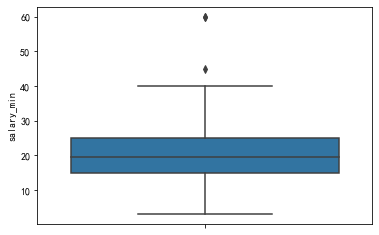

In [520]:
sns.boxplot(y='salary_min', data=lagou)

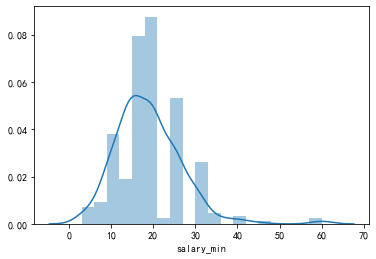

In [521]:
sns.distplot(lagou['salary_min'])

- 该岗位的最低薪酬在3k-60k范围内
- 40多k和60k是个别情况
- 75%的公司的最低薪酬在25k以下
- 大部分公司能提供的最低薪酬为20k

In [522]:
# 查看最高薪酬的情况
lagou['salary_max'].describe()

count    282.000000
mean      33.308511
std       13.077127
min        6.000000
25%       25.000000
50%       30.000000
75%       40.000000
max       70.000000
Name: salary_max, dtype: float64

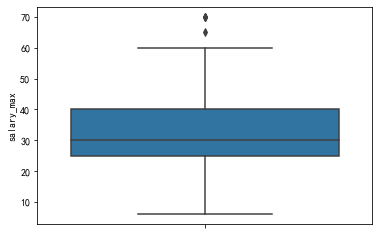

In [523]:
sns.boxplot(y='salary_max', data=lagou)

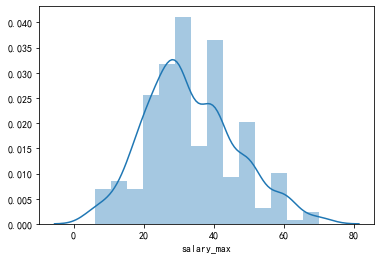

In [524]:
sns.distplot(lagou['salary_max'])

- 该岗位的最高薪酬在6k-70k之间
- 65k和70k是个别情况，应该是对应上面的最低薪酬40多k和60k
- 75%的公司可提供的最高薪酬在40k以下
- 大部分公司能提供的最高薪酬为30k

In [525]:
# 查看平均薪酬情况
# 创建平均薪酬字段
lagou['salary_avg'] = (lagou['salary_max'] - lagou['salary_min'])/2 + lagou['salary_min']

In [526]:
lagou['salary_avg'].describe()

count    282.000000
mean      26.090426
std       10.280314
min        4.500000
25%       20.000000
50%       24.000000
75%       32.125000
max       65.000000
Name: salary_avg, dtype: float64

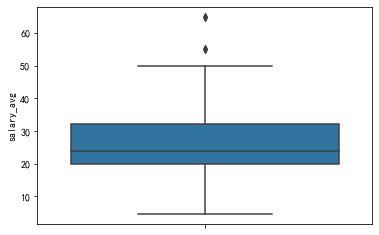

In [527]:
sns.boxplot(y='salary_avg', data=lagou)

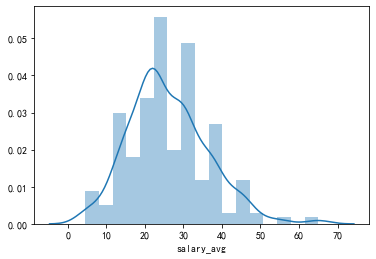

In [528]:
sns.distplot(lagou['salary_avg'])

- 该岗位的平均薪酬在4.5k-65k之间
- 75%的公司可提供的平均薪酬为32k以下
- 大部分公司能提供的平均薪酬为25k

### 查看不同公司的岗位需求量

In [529]:
lagou['company'].value_counts()

网易                        15
小鹏汽车                      14
欢聚集团（JOYY Inc.）           10
酷狗音乐                       9
DMAI智能科技                   7
紫为云（北京）智能科技有限公司            7
深声科技                       5
诚迈信息                       5
唯品会                        4
虎牙科技                       4
三七互娱                       4
参数                         4
广州市奥威亚电子科技有限公司             4
CVTE                       4
腾讯                         3
百布                         3
荔枝                         3
柏视医疗                       3
太平洋网络有限公司                  3
广东亿迅                       3
派客朴食                       3
美业颜究院                      3
趣丸                         3
ImageDT图匠数据                3
广州棒谷科技股份有限公司               3
玄武科技                       3
广发银行信用卡中心                  3
时谛智能                       3
微革网络                       2
联通（广东）产业互联网...             2
                          ..
聚焦网络集团                     1
博纳德                        1
广州奕才企业管理顾问有限公司             1
博冠            

<Figure size 2160x1440 with 0 Axes>

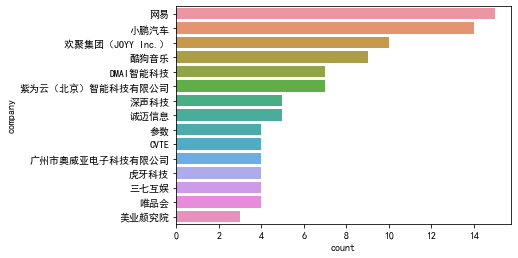

<Figure size 2160x1440 with 0 Axes>

In [530]:
sns.countplot(y='company', data=lagou, order=lagou['company'].value_counts().sort_values(ascending=False).head(15).index) # 只画前15个
plt.figure(figsize=(30,20))

- 有149家公司对该岗位有需求
- 对该岗位需求量最大的是网易，达到了15个，其次是小鹏汽车（14个）、欢聚集团（10个）、酷狗音乐（9个）、DMAI智能科技和紫为云（北京）智能科技有限公司（7个）

### 查看不同经验要求的岗位需求量

In [531]:
lagou.groupby(['experience'])['title'].count()

experience
经验1-3年      63
经验3-5年     116
经验5-10年     26
经验不限        45
经验在校        32
Name: title, dtype: int64

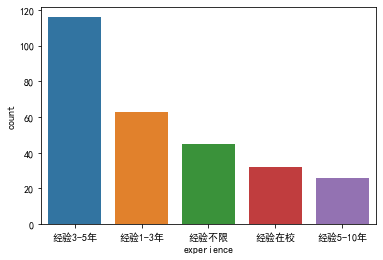

In [532]:
sns.countplot(x='experience', data=lagou, order=lagou.groupby(['experience']).count().sort_values(by='title',ascending=False).index)

- 要求经验3-5年的岗位需求量最多
- 要求经验5-10年的岗位需求量最少

### 查看不同学历要求的岗位需求量

In [533]:
lagou['qualification'].value_counts()

本科    198
硕士     70
不限     11
博士      2
大专      1
Name: qualification, dtype: int64

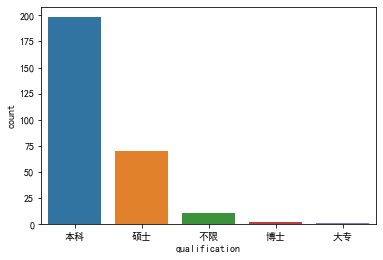

In [534]:
sns.countplot(x='qualification', data=lagou, order=lagou['qualification'].value_counts().sort_values(ascending=False).index)

- 本科学历要求的岗位需求量最多，其次是硕士学历
- 大专学历要求的需求量最少

### 查看不同融资情况公司的岗位需求量

In [535]:
lagou['finance'].value_counts()

上市公司     107
不需要融资     67
未融资       31
A轮        26
B轮        25
天使轮       11
C轮         8
D轮及以上      7
Name: finance, dtype: int64

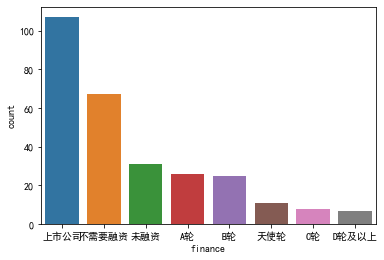

In [536]:
sns.countplot(x='finance', data=lagou, order=lagou['finance'].value_counts().sort_values(ascending=False).index)

- 上市公司对该岗位的需求量最大，其次是不需要融资和未融资的公司
- D轮及以上的企业对该岗位的需求量最少

### 查看不同规模公司的岗位需求量

In [537]:
lagou['scale'].value_counts()

2000人以上      97
500-2000人    63
50-150人      47
150-500人     45
15-50人       25
少于15人         5
Name: scale, dtype: int64

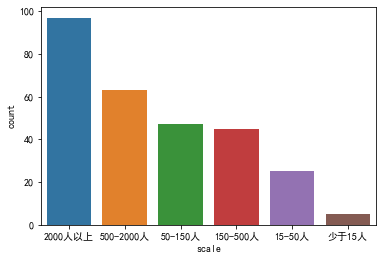

In [538]:
sns.countplot(x='scale', data=lagou, order=lagou['scale'].value_counts().sort_values(ascending=False).index)

- 2000人以上规模的公司对该岗位的需求量最大，其次是500-2000人和50-150人的
- 少于15人的规模的公司的需求量最少

### 查看不同行业领域的公司的岗位需求量

In [539]:
lagou['uni_domain'].value_counts()

人工智能      41
数据服务      27
电商平台      22
内容资讯      20
游戏        19
移动互联网     19
制造业       16
软件服务      14
音频        12
社交媒体      12
智能硬件       8
医疗         7
工具类产品      7
IT技术服务     6
硬件         6
科技金融       4
其他         4
物联网        4
金融业        4
企业服务       4
网络通信       3
电商         3
教育         2
房地产        2
在线教育       2
文化传媒       2
营销服务       2
旅游         2
新零售        2
汽车         1
社交平台       1
信息安全       1
休闲         1
MCN        1
文娱         1
Name: uni_domain, dtype: int64

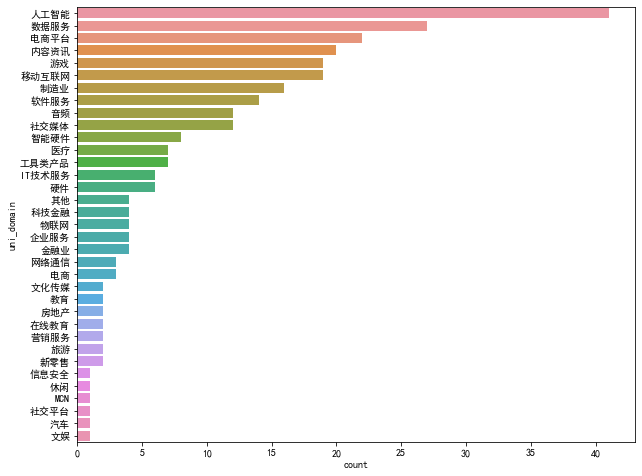

In [540]:
plt.figure(figsize=(10, 8))
sns.countplot(y='uni_domain', data=lagou, order=lagou['uni_domain'].value_counts().sort_values(ascending=False).index)

- 人工智能服务行业领域的公司对该岗位的需求量比较大，有38家公司
- 其次是数据服务、电商平台、内容咨询、游戏、移动互联网

## 多变量

### 其他变量和薪酬的关系

#### 查看不同公司的薪酬情况

In [541]:
tmp = lagou.groupby(['company'])['salary_avg'].mean().sort_values(ascending=False)
tmpdf = pd.DataFrame(tmp).reset_index()
tmpdf_30 =  tmpdf[tmpdf['salary_avg']>30]  # 查看提供该岗位的平均薪资大于25k的公司
tmpdf_30

,company,salary_avg
0,金地,65.000000
1,Mobvista,55.000000
2,川山教育,45.000000
3,Fordeal,42.500000
4,玄武科技,42.500000
5,忘平科技,42.500000
6,搜款网 VVIC,41.250000
7,Bigo,40.500000
8,锟元方青医疗科技,40.000000
9,虎牙科技,39.375000


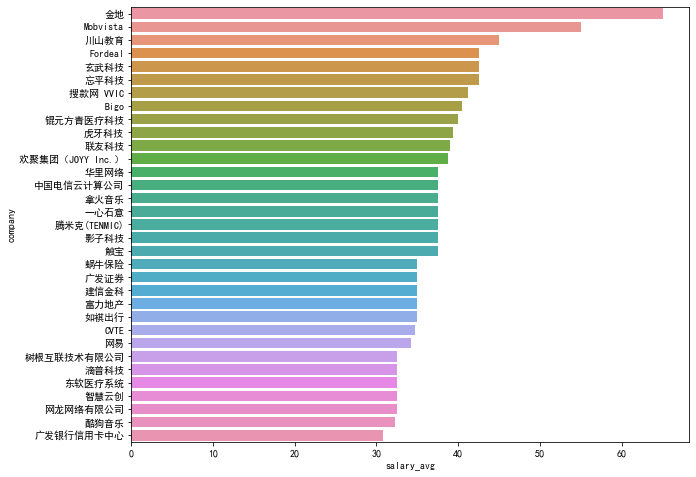

In [542]:
plt.figure(figsize=(10, 8))
sns.barplot(y='company', x='salary_avg', data=tmpdf_30)

- 可以看到，能够提供平均薪酬在30k以上的公司有32家
- 其中，金地提供的平均薪酬最高，为65k，属于个别情况
- 然后是Mobvista，川山教育，Fordeal，玄武科技，忘平科技

#### 查看不同经验要求的薪酬情况

In [543]:
lagou.groupby(['experience'])['salary_avg'].describe()

,count,mean,std,min,25%,50%,75%,max
experience,,,,,,,,
经验1-3年,63.0,23.730159,7.979725,11.5,17.75,22.5,27.500,45.0
经验3-5年,116.0,28.331897,8.959557,5.5,22.50,30.0,35.000,55.0
经验5-10年,26.0,33.750000,9.290048,16.5,27.50,32.5,39.375,55.0
经验不限,45.0,24.777778,8.921728,5.0,20.00,22.5,30.000,45.0
经验在校,32.0,18.234375,14.308234,4.5,10.00,15.0,20.000,65.0


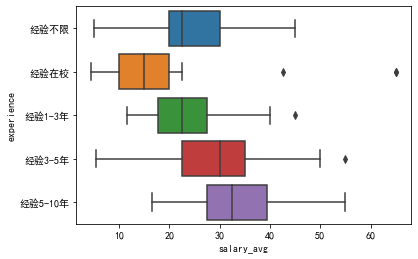

In [544]:
sns.boxplot(x='salary_avg', y='experience', data=lagou)

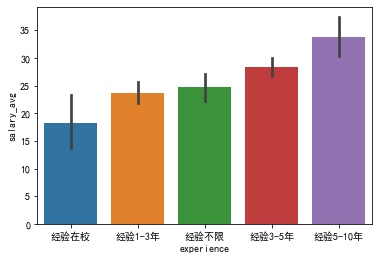

In [545]:
sns.barplot(x='experience', y='salary_avg',data=lagou, order=lagou.groupby(['experience'])['salary_avg'].mean().sort_values().index)

- 整体而言，经验越多，薪资越高
- 经验5-10的薪资最高，其次是3-5年的,应届生薪资最低
- 经验5-10年和经验3-5年的薪资离散度是较大的，说明这时候跳槽可能会拿到较高的薪资

#### 查看不同学历要求的薪酬情况

In [546]:
lagou.groupby(['qualification'])['salary_avg'].describe()

,count,mean,std,min,25%,50%,75%,max
qualification,,,,,,,,
不限,11.0,30.000000,19.547378,8.0,15.50,22.50,36.25,65.0
博士,2.0,34.500000,14.849242,24.0,29.25,34.50,39.75,45.0
大专,1.0,5.500000,NaN,5.5,5.50,5.50,5.50,5.5
本科,198.0,25.648990,9.610130,4.5,20.00,22.75,30.00,50.0
硕士,70.0,26.778571,9.822200,5.0,20.00,26.50,32.50,55.0


- 大专的std为NaN是因为只有一个数据

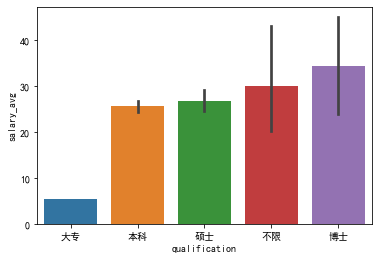

In [547]:
sns.barplot(x='qualification', y='salary_avg', data=lagou, order=lagou.groupby(['qualification'])['salary_avg'].mean().sort_values().index)

- 随着学历增高，薪资也增高
- 出乎意料的是，硕士和本科的平均薪资水平差不多,为25k左右
- 不限和博士学历的平均薪资离散度较大

#### 查看不同融资情况公司的薪酬情况

In [548]:
lagou.groupby(['finance'])['salary_avg'].describe()

,count,mean,std,min,25%,50%,75%,max
finance,,,,,,,,
A轮,26.0,25.423077,6.823038,5.0,22.5,27.5,30.000,37.5
B轮,25.0,20.760000,8.878955,5.0,16.0,22.5,24.000,45.0
C轮,8.0,30.250000,8.992060,19.5,22.5,30.0,34.375,45.0
D轮及以上,7.0,24.714286,3.795361,20.0,21.5,25.0,27.500,30.0
上市公司,107.0,31.060748,10.381113,12.5,22.5,30.0,37.500,65.0
不需要融资,67.0,22.537313,9.630017,5.5,15.0,22.0,27.500,47.5
天使轮,11.0,24.818182,8.623435,13.0,20.0,22.5,30.000,40.0
未融资,31.0,21.161290,9.251475,4.5,15.0,18.5,25.500,45.0


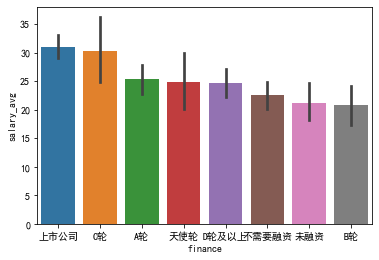

In [549]:
sns.barplot(x='finance', y='salary_avg', data=lagou, order=lagou.groupby(['finance'])['salary_avg'].mean().sort_values(ascending=False).index)

- 上市公司能提供的平均薪水最高，其次是C轮、A轮、天使轮、D轮及以上

#### 查看不同规模公司的薪酬情况

In [550]:
lagou.groupby(['scale'])['salary_avg'].describe()

,count,mean,std,min,25%,50%,75%,max
scale,,,,,,,,
15-50人,25.0,20.680000,7.305648,4.5,15.00,20.0,25.00,37.5
150-500人,45.0,23.877778,8.152771,5.0,20.00,23.0,30.00,45.0
2000人以上,97.0,30.484536,10.695466,8.0,22.50,30.0,37.50,65.0
50-150人,47.0,22.106383,9.035519,5.5,15.00,22.0,26.25,45.0
500-2000人,63.0,26.071429,10.512610,5.0,18.25,24.0,32.75,55.0
少于15人,5.0,25.500000,9.082951,15.0,22.50,25.0,25.00,40.0


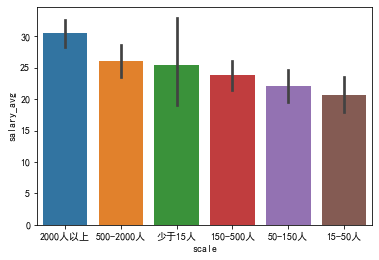

In [551]:
sns.barplot(x='scale', y='salary_avg', data=lagou, order=lagou.groupby(['scale'])['salary_avg'].mean().sort_values(ascending=False).index)

- 2000人以上规模的公司提供的平均薪水最高，其次是500-2000人的
- 15-50人的公司提供的平均薪水最低

#### 查看不同领域公司的薪酬情况

In [552]:
lagou.groupby(['uni_domain'])['salary_avg'].mean().sort_values(ascending=False)

uni_domain
营销服务      41.250000
社交媒体      39.041667
休闲        37.500000
旅游        35.000000
教育        33.750000
金融业       31.875000
音频        31.250000
内容资讯      30.900000
社交平台      30.000000
房地产       27.500000
新零售       27.500000
游戏        27.289474
科技金融      27.000000
工具类产品     25.357143
制造业       25.218750
电商平台      25.090909
医疗        24.857143
人工智能      24.756098
移动互联网     24.578947
电商        24.166667
数据服务      24.018519
硬件        23.833333
软件服务      23.357143
在线教育      23.250000
IT技术服务    22.750000
MCN       22.500000
网络通信      22.333333
文化传媒      21.250000
企业服务      20.625000
物联网       20.125000
其他        20.125000
智能硬件      19.500000
文娱        18.500000
信息安全      16.500000
汽车        15.000000
Name: salary_avg, dtype: float64

In [553]:
lagou.groupby(['uni_domain'])['salary_avg'].describe()

,count,mean,std,min,25%,50%,75%,max
uni_domain,,,,,,,,
IT技术服务,6.0,22.750000,3.856812,19.0,20.625,22.50,22.500,30.0
MCN,1.0,22.500000,NaN,22.5,22.500,22.50,22.500,22.5
人工智能,41.0,24.756098,10.723294,4.5,20.000,24.00,30.000,55.0
企业服务,4.0,20.625000,5.153882,15.0,16.875,21.25,25.000,25.0
休闲,1.0,37.500000,NaN,37.5,37.500,37.50,37.500,37.5
信息安全,1.0,16.500000,NaN,16.5,16.500,16.50,16.500,16.5
其他,4.0,20.125000,9.132132,8.0,17.000,21.25,24.375,30.0
内容资讯,20.0,30.900000,8.320235,15.0,22.500,31.25,37.500,45.0
制造业,16.0,25.218750,5.618329,19.0,19.750,25.00,30.000,35.5


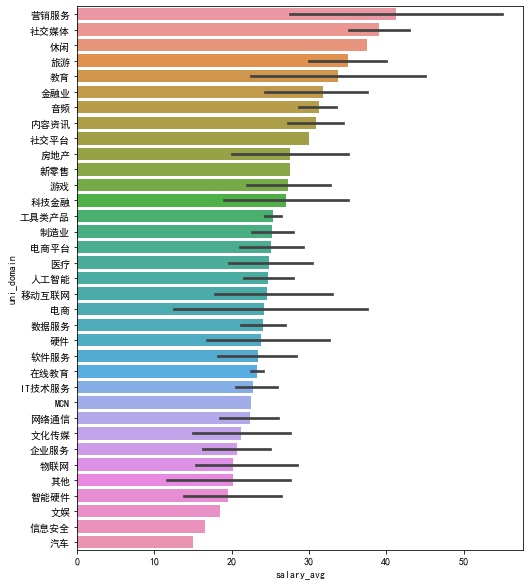

In [554]:
plt.figure(figsize=(8, 10))
sns.barplot(y='uni_domain', x='salary_avg', data=lagou, order=lagou.groupby(['uni_domain'])['salary_avg'].mean().sort_values(ascending=False).index)

- 营销服务领域的公司提供的平均薪水最高（41k），其次是社交媒体（39k）、休闲（37k）、旅游（35k）、教育（33k）
- 汽车行业的公司提供的平均薪水最少

### 其他变量和学历要求的关系

#### 查看不同公司对学历的要求

In [555]:
# 有本科学历要求的公司
qc = lagou[lagou['qualification'] == '本科']['company'].value_counts()
qcdf = pd.DataFrame(qc).reset_index()
qcdf = qcdf.rename({'index':'company', 'company': 'count'}, axis=1)
qcdf

,company,count
0,网易,13
1,小鹏汽车,8
2,欢聚集团（JOYY Inc.）,8
3,酷狗音乐,8
4,紫为云（北京）智能科技有限公司,6
5,诚迈信息,5
6,唯品会,4
7,DMAI智能科技,4
8,深声科技,4
9,虎牙科技,4


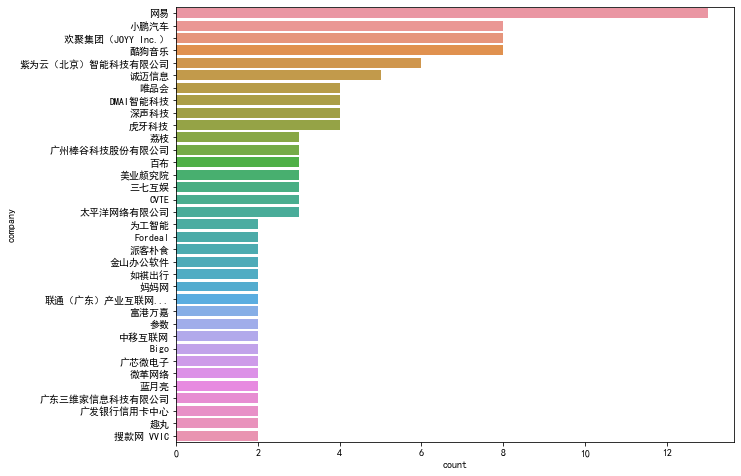

In [556]:
plt.figure(figsize=(10, 8))
sns.barplot(y='company', x='count', data=qcdf[qcdf['count']>1])


- 对该岗位有本科学历要求的公司有112家
- 对该岗位有本科学历要求的最多的是网易公司，有13个
- 其次是小鹏汽车、欢聚集团、酷狗音乐（8个）

In [557]:
# 有硕士学历要求的公司
qc = lagou[lagou['qualification'] == '硕士']['company'].value_counts()
qcdf = pd.DataFrame(qc).reset_index()
qcdf = qcdf.rename({'index':'company', 'company': 'count'}, axis=1)
qcdf

,company,count
0,小鹏汽车,4
1,广州市奥威亚电子科技有限公司,4
2,ImageDT图匠数据,3
3,时谛智能,3
4,DMAI智能科技,3
5,柏视医疗,3
6,联友科技,2
7,XAG极飞科技,2
8,玄武科技,2
9,参数,2


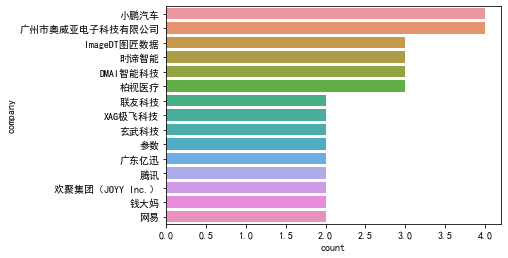

In [558]:
sns.barplot(y='company', x='count', data=qcdf[qcdf['count']>1])

- 对该岗位有硕士学历要求的公司有47家
- 对该岗位有硕士学历要求的最多的是小鹏汽车、广州市奥威亚电子科技有限公司，有4个
- 其次是ImageDT图匠数据、时谛智能、DMAI智能科技、柏视医疗（3个）

In [559]:
# 有博士学历要求的公司
qc = lagou[lagou['qualification'] == '博士']['company'].value_counts()
qcdf = pd.DataFrame(qc).reset_index()
qcdf = qcdf.rename({'index':'company', 'company': 'count'}, axis=1)
qcdf

,company,count
0,CVTE,1
1,广东瀚阳轨道信息科技...,1


- 对该岗位有博士学历要求的只有CVTE和广东瀚阳轨道信息科技公司,只有1个

In [560]:
# 不限学历要求的公司
qc = lagou[lagou['qualification'] == '不限']['company'].value_counts()
qcdf = pd.DataFrame(qc).reset_index()
qcdf = qcdf.rename({'index':'company', 'company': 'count'}, axis=1)
qcdf

,company,count
0,小鹏汽车,2
1,金地,2
2,偶家科技,1
3,紫为云（北京）智能科技有限公司,1
4,三七互娱,1
5,广数,1
6,蜗牛保险,1
7,易站通,1
8,多益网络,1


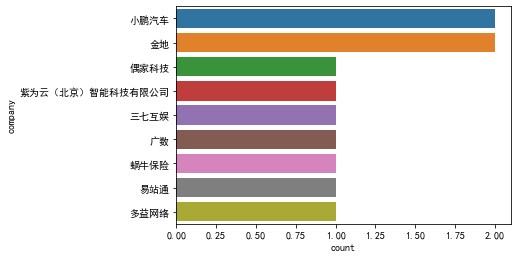

In [561]:
sns.barplot(y='company', x='count', data=qcdf)

- 只有9家公司不限学历，小鹏汽车和金地公司各有2个，其余只有1个

- 上述分析说明大多数公司对学历的要求还是本科学历和硕士学历

#### 查看不同融资情况公司对学历的要求

In [562]:
lagou.groupby(['finance'])['qualification'].value_counts()

finance  qualification
A轮       本科               13
         硕士               11
         不限                2
B轮       本科               19
         硕士                5
         不限                1
C轮       本科                5
         硕士                3
D轮及以上    本科                4
         硕士                3
上市公司     本科               79
         硕士               22
         不限                5
         博士                1
不需要融资    本科               47
         硕士               16
         不限                2
         博士                1
         大专                1
天使轮      本科                9
         硕士                2
未融资      本科               22
         硕士                8
         不限                1
Name: qualification, dtype: int64

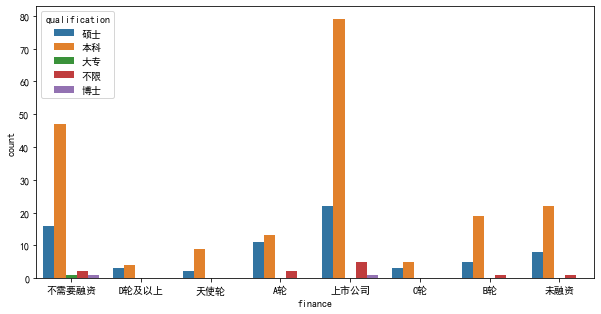

In [563]:
plt.figure(figsize=(10, 5))
sns.countplot(x='finance', hue='qualification', data=lagou)

- 不管是什么融资情况的公司，对学历要求为本科都是最多的，其次是硕士学历
- D轮及以上、天使轮、C轮公司只有本科和硕士的要求
- A轮、B轮、未融资公司只有本科、硕士和不限的要求

#### 查看不同规模公司对学历的要求

In [564]:
lagou.groupby(['scale'])['qualification'].value_counts()

scale      qualification
15-50人     本科               21
           硕士                3
           不限                1
150-500人   本科               24
           硕士               20
           不限                1
2000人以上    本科               71
           硕士               19
           不限                6
           博士                1
50-150人    本科               33
           硕士               11
           不限                1
           博士                1
           大专                1
500-2000人  本科               45
           硕士               16
           不限                2
少于15人      本科                4
           硕士                1
Name: qualification, dtype: int64

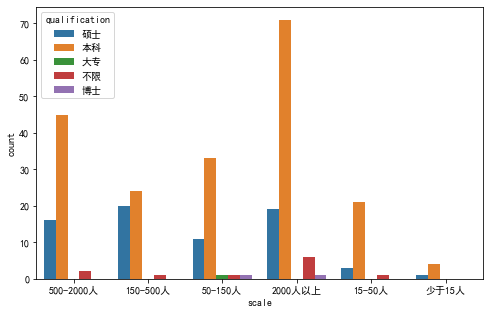

In [565]:
plt.figure(figsize=(8, 5))
sns.countplot(x='scale', hue='qualification', data=lagou)

- 不管是什么规模的公司，对学历要求为本科都是最多的，其次是硕士学历
- 只有50-150人的公司提供的该岗位覆盖了所有可能的学历要求

#### 查看不同领域公司对学历的要求

In [594]:
# 有本科学历要求的领域
qd = lagou[lagou['qualification'] == '本科']['uni_domain'].value_counts()
qddf = pd.DataFrame(qd).reset_index()
qddf = qddf.rename({'index':'uni_domain', 'uni_domain': 'count'}, axis=1)
qddf

,uni_domain,count
0,电商平台,22
1,人工智能,22
2,内容资讯,18
3,数据服务,18
4,游戏,14
5,音频,11
6,移动互联网,10
7,制造业,10
8,社交媒体,10
9,软件服务,8


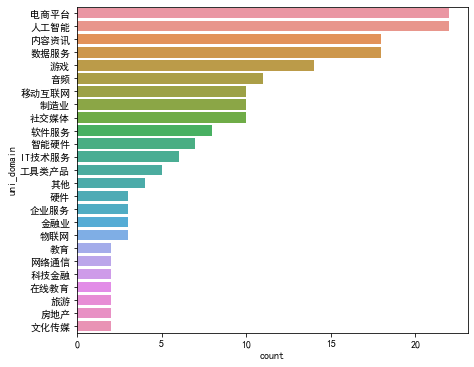

In [597]:
plt.figure(figsize=(7, 6))
sns.barplot(y='uni_domain', x='count', data=qddf[qddf['count']>1])


- 对该岗位有本科学历要求的主要在电商平台和人工智能领域
- 其次是内容咨询、数据服务、游戏、音频

In [598]:
# 有硕士学历要求的领域
qd = lagou[lagou['qualification'] == '硕士']['uni_domain'].value_counts()
qddf = pd.DataFrame(qd).reset_index()
qddf = qddf.rename({'index':'uni_domain', 'uni_domain': 'count'}, axis=1)
qddf

,uni_domain,count
0,人工智能,18
1,数据服务,8
2,医疗,6
3,软件服务,6
4,移动互联网,4
5,制造业,4
6,游戏,3
7,社交媒体,2
8,电商,2
9,工具类产品,2


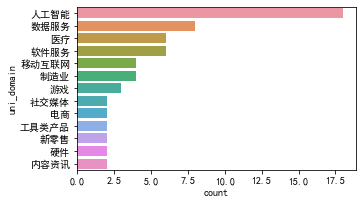

In [600]:
plt.figure(figsize=(5, 3))
sns.barplot(y='uni_domain', x='count', data=qddf[qddf['count']>1])


- 对该岗位有硕士学历要求的主要在人工智能领域
- 其次是数据服务、医疗、软件服务、移动互联网、制造业

In [601]:
# 有博士学历要求的领域
qd = lagou[lagou['qualification'] == '博士']['uni_domain'].value_counts()
qddf = pd.DataFrame(qd).reset_index()
qddf = qddf.rename({'index':'uni_domain', 'uni_domain': 'count'}, axis=1)
qddf

,uni_domain,count
0,硬件,1
1,数据服务,1


- 对该岗位有博士学历要求的主要在硬件和数据服务领域

In [604]:
# 不限学历要求的领域
qd = lagou[lagou['qualification'] == '不限']['uni_domain'].value_counts()
qddf = pd.DataFrame(qd).reset_index()
qddf = qddf.rename({'index':'uni_domain', 'uni_domain': 'count'}, axis=1)
qddf

,uni_domain,count
0,移动互联网,4
1,游戏,2
2,制造业,2
3,科技金融,1
4,智能硬件,1
5,人工智能,1


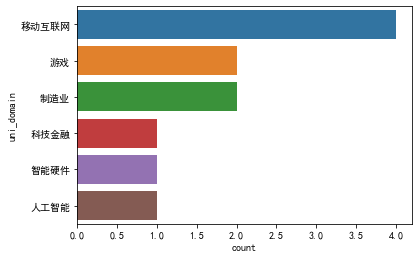

In [606]:
sns.barplot(y='uni_domain', x='count', data=qddf)

- 对该岗位不限学历要求的主要在移动互联网领域
- 其次是游戏、制造业

### 其他变量和经验要求的关系

#### 查看不同公司对经验要求的情况

In [567]:
# 有经验在校（应届）要求的公司
qe = lagou[lagou['experience'] == '经验在校']['company'].value_counts()
qedf = pd.DataFrame(qe).reset_index()
qedf = qedf.rename({'index':'company', 'company': 'count'}, axis=1)
qedf

,company,count
0,小鹏汽车,5
1,三七互娱,3
2,广州市奥威亚电子科技有限公司,2
3,趣丸,2
4,金地,2
5,极点三维,1
6,为工智能,1
7,广数,1
8,派客朴食,1
9,高新兴科技集团,1


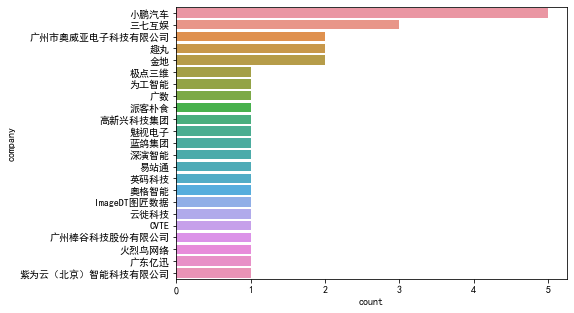

In [568]:
plt.figure(figsize=(7, 5))
sns.barplot(y='company', x='count', data=qedf)


- 对该岗位有应届要求的公司有23家
- 对该岗位有应届要求的最多的公司是小鹏汽车（5个）
- 其次是三七互娱（3个）、广州市奥威亚电子科技有限公司、趣丸、金地（2个）

In [569]:
# 有经验1-3年要求的公司
qe = lagou[lagou['experience'] == '经验1-3年']['company'].value_counts()
qedf = pd.DataFrame(qe).reset_index()
qedf = qedf.rename({'index':'company', 'company': 'count'}, axis=1)
qedf

,company,count
0,网易,6
1,参数,4
2,诚迈信息,4
3,衡昊数据,2
4,广州棒谷科技股份有限公司,2
5,金山办公软件,2
6,腾讯,2
7,太平洋网络有限公司,1
8,欢聚集团（JOYY Inc.）,1
9,叶浪智能,1


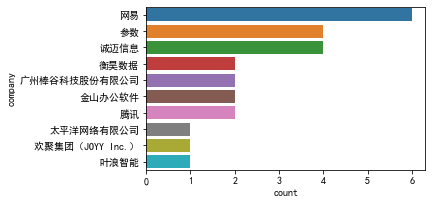

In [570]:
plt.figure(figsize=(5, 3))
sns.barplot(y='company', x='count', data=qedf.head(10))


- 对该岗位有经验1-3年要求的公司有48家
- 对该岗位有经验1-3年要求的最多的公司是网易（6个）
- 其次是参数、诚迈信息（4个）

In [571]:
# 有经验3-5年要求的公司
qe = lagou[lagou['experience'] == '经验3-5年']['company'].value_counts()
qedf = pd.DataFrame(qe).reset_index()
qedf = qedf.rename({'index':'company', 'company': 'count'}, axis=1)
qedf

,company,count
0,酷狗音乐,8
1,网易,7
2,欢聚集团（JOYY Inc.）,6
3,小鹏汽车,5
4,虎牙科技,4
5,DMAI智能科技,4
6,美业颜究院,3
7,唯品会,3
8,深声科技,3
9,荔枝,3


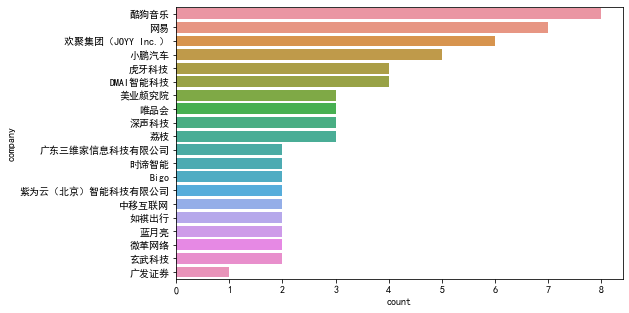

In [572]:
plt.figure(figsize=(8, 5))
sns.barplot(y='company', x='count', data=qedf.head(20))


- 对该岗位有经验3-5年要求的公司有71家
- 对该岗位有经验3-5年要求的最多的公司是酷狗音乐（8个）
- 其次是网易（7个）、欢聚集团（6个）、小鹏汽车（5个）、虎牙科技、DMAI智能科技（4个）、美业颜究院、唯品会、深声科技、荔枝（3个）

In [573]:
# 有经验5-10年要求的公司
qe = lagou[lagou['experience'] == '经验5-10年']['company'].value_counts()
qedf = pd.DataFrame(qe).reset_index()
qedf = qedf.rename({'index':'company', 'company': 'count'}, axis=1)
qedf

,company,count
0,联友科技,2
1,广发银行信用卡中心,2
2,百布,2
3,搜款网 VVIC,2
4,一手,1
5,南方报业,1
6,联通（广东）产业互联网...,1
7,智慧云创,1
8,川山教育,1
9,腾米克(TENMIC),1


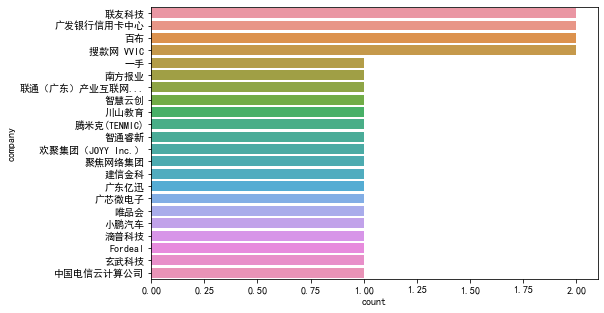

In [574]:
plt.figure(figsize=(8, 5))
sns.barplot(y='company', x='count', data=qedf)


- 对该岗位有经验5-10年要求的公司有22家
- 对该岗位有经验5-10年要求的最多的公司有联友科技、广发银行信用卡中心、百布、搜款网、VVIC（2个）

In [575]:
# 对经验不限要求的公司
qe = lagou[lagou['experience'] == '经验不限']['company'].value_counts()
qedf = pd.DataFrame(qe).reset_index()
qedf = qedf.rename({'index':'company', 'company': 'count'}, axis=1)
qedf

,company,count
0,紫为云（北京）智能科技有限公司,3
1,柏视医疗,3
2,欢聚集团（JOYY Inc.）,2
3,网易,2
4,CVTE,2
5,深声科技,2
6,小鹏汽车,2
7,DMAI智能科技,2
8,XAG极飞科技,2
9,广州市奥威亚电子科技有限公司,1


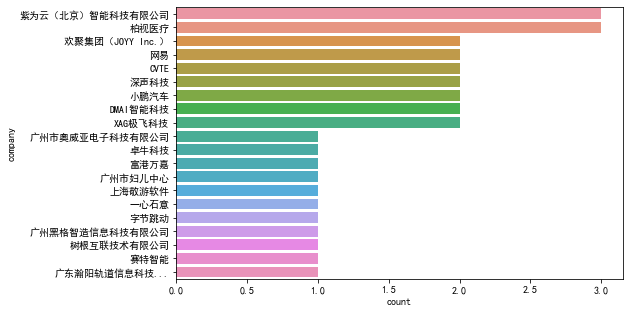

In [576]:
plt.figure(figsize=(8, 5))
sns.barplot(y='company', x='count', data=qedf.head(20))


- 对该岗位经验不限要求的公司有34家
- 对该岗位经验不限要求的最多的公司有紫为云（北京）智能科技有限公司、柏视医疗（3个）

#### 查看不同融资情况公司对经验要求的情况

In [577]:
lagou.groupby(['finance'])['experience'].value_counts()

finance  experience
A轮       经验3-5年        12
         经验不限           6
         经验1-3年         5
         经验5-10年        2
         经验在校           1
B轮       经验3-5年        14
         经验1-3年         6
         经验在校           3
         经验不限           2
C轮       经验3-5年         3
         经验不限           3
         经验5-10年        2
D轮及以上    经验3-5年         2
         经验5-10年        2
         经验1-3年         1
         经验不限           1
         经验在校           1
上市公司     经验3-5年        53
         经验1-3年        22
         经验在校          15
         经验不限          12
         经验5-10年        5
不需要融资    经验3-5年        22
         经验1-3年        13
         经验不限          13
         经验5-10年       10
         经验在校           9
天使轮      经验1-3年         4
         经验3-5年         4
         经验不限           3
未融资      经验1-3年        12
         经验3-5年         6
         经验5-10年        5
         经验不限           5
         经验在校           3
Name: experience, dtype: int64

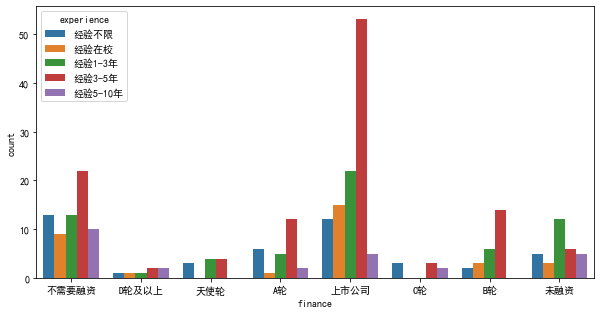

In [578]:
plt.figure(figsize=(10, 5))
sns.countplot(x='finance', hue='experience', data=lagou)

- 上市公司、不需要融资、A轮、B轮公司对该岗位要求为经验3-5年的需求量最多
- 未融资公司对该岗位要求为经验1-3年的需求量最多
- D轮及以上、天使轮、C轮对该岗位的经验要求区别不大

#### 查看不同规模公司对经验要求的情况

In [579]:
lagou.groupby(['scale'])['experience'].value_counts()

scale      experience
15-50人     经验1-3年        13
           经验3-5年         6
           经验不限           3
           经验在校           2
           经验5-10年        1
150-500人   经验3-5年        19
           经验1-3年        10
           经验不限          10
           经验在校           5
           经验5-10年        1
2000人以上    经验3-5年        40
           经验1-3年        20
           经验在校          15
           经验不限          13
           经验5-10年        9
50-150人    经验3-5年        20
           经验不限          11
           经验1-3年        10
           经验5-10年        4
           经验在校           2
500-2000人  经验3-5年        29
           经验5-10年       11
           经验不限           8
           经验在校           8
           经验1-3年         7
少于15人      经验1-3年         3
           经验3-5年         2
Name: experience, dtype: int64

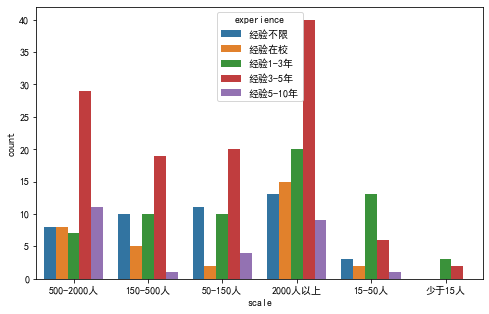

In [580]:
plt.figure(figsize=(8, 5))
sns.countplot(x='scale', hue='experience', data=lagou)

- 2000人以上、500-2000人、150-500人、50-150人规模的公司对该岗位要求为经验3-5年的需求量最多
- 15-50人和少于15人规模的公司对该岗位要求为经验1-3年的需求量最多

#### 查看不同领域公司对经验要求的情况

In [607]:
# 有经验在校（应届）要求的领域
ed = lagou[lagou['experience'] == '经验在校']['uni_domain'].value_counts()
eddf = pd.DataFrame(ed).reset_index()
eddf = eddf.rename({'index':'uni_domain', 'uni_domain': 'count'}, axis=1)
eddf

,uni_domain,count
0,游戏,6
1,人工智能,6
2,制造业,5
3,移动互联网,4
4,软件服务,3
5,数据服务,2
6,智能硬件,1
7,物联网,1
8,其他,1
9,硬件,1


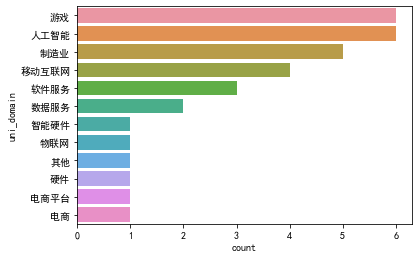

In [609]:
sns.barplot(y='uni_domain', x='count', data=eddf)

- 对该岗位有应届要求的主要是游戏和人工智能领域
- 其次是制造业、移动互联网、软件服务、数据服务

In [610]:
# 有经验1-3年要求的领域
ed = lagou[lagou['experience'] == '经验1-3年']['uni_domain'].value_counts()
eddf = pd.DataFrame(ed).reset_index()
eddf = eddf.rename({'index':'uni_domain', 'uni_domain': 'count'}, axis=1)
eddf

,uni_domain,count
0,内容资讯,8
1,移动互联网,7
2,人工智能,6
3,工具类产品,6
4,数据服务,6
5,电商平台,4
6,IT技术服务,4
7,智能硬件,3
8,软件服务,3
9,医疗,3


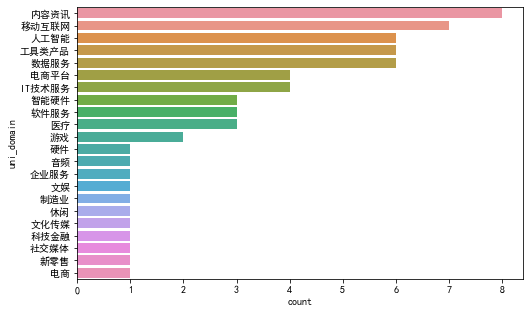

In [612]:
plt.figure(figsize=(8, 5))
sns.barplot(y='uni_domain', x='count', data=eddf)

- 对该岗位有经验1-3年要求的主要是内容咨询领域
- 其次是移动互联网、人工智能、工具类产品、数据服务

In [613]:
# 有经验3-5年要求的领域
ed = lagou[lagou['experience'] == '经验3-5年']['uni_domain'].value_counts()
eddf = pd.DataFrame(ed).reset_index()
eddf = eddf.rename({'index':'uni_domain', 'uni_domain': 'count'}, axis=1)
eddf

,uni_domain,count
0,人工智能,17
1,数据服务,13
2,音频,11
3,电商平台,9
4,内容资讯,8
5,社交媒体,8
6,游戏,7
7,制造业,7
8,软件服务,4
9,移动互联网,4


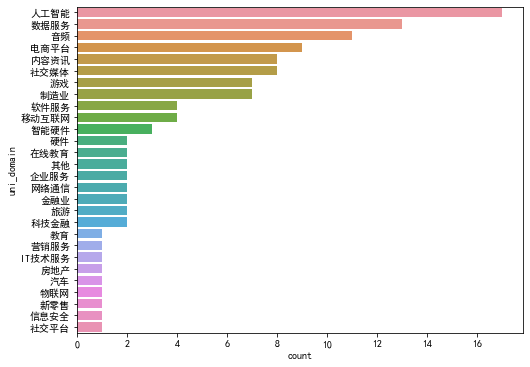

In [617]:
plt.figure(figsize=(8, 6))
sns.barplot(y='uni_domain', x='count', data=eddf)

- 对该岗位有经验3-5年要求的主要是人工智能领域
- 其次是数据服务、音频、电商平台

In [618]:
# 有经验5-10年要求的领域
ed = lagou[lagou['experience'] == '经验5-10年']['uni_domain'].value_counts()
eddf = pd.DataFrame(ed).reset_index()
eddf = eddf.rename({'index':'uni_domain', 'uni_domain': 'count'}, axis=1)
eddf

,uni_domain,count
0,电商平台,7
1,软件服务,3
2,移动互联网,2
3,金融业,2
4,人工智能,2
5,数据服务,2
6,科技金融,1
7,营销服务,1
8,社交媒体,1
9,文化传媒,1


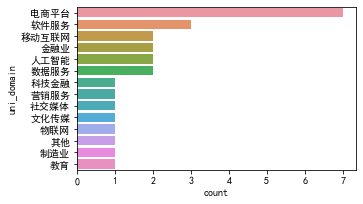

In [620]:
plt.figure(figsize=(5, 3))
sns.barplot(y='uni_domain', x='count', data=eddf)

- 对该岗位有经验5-10年要求的主要是电商平台领域
- 其次是软件服务

In [621]:
# 经验不限要求的领域
ed = lagou[lagou['experience'] == '经验不限']['uni_domain'].value_counts()
eddf = pd.DataFrame(ed).reset_index()
eddf = eddf.rename({'index':'uni_domain', 'uni_domain': 'count'}, axis=1)
eddf

,uni_domain,count
0,人工智能,10
1,游戏,4
2,内容资讯,4
3,医疗,4
4,数据服务,4
5,社交媒体,2
6,硬件,2
7,制造业,2
8,移动互联网,2
9,企业服务,1


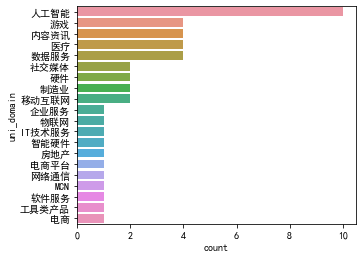

In [623]:
plt.figure(figsize=(5, 4))
sns.barplot(y='uni_domain', x='count', data=eddf)

- 对该岗位经验不限的主要是人工智能领域

# 结论

- 关于该岗位的总体薪酬情况：
    - 最低薪酬：该岗位的最低薪酬在3k-60k范围内,大部分公司能提供的最低薪酬为20k
    - 最高薪酬：该岗位的最高薪酬在6k-70k之间,大部分公司能提供的最高薪酬为30k
    - 平均薪酬：该岗位的平均薪酬在4.5k-65k之间,大部分公司能提供的平均薪酬为25k
- 关于该岗位的需求量情况：
    - 公司：对该岗位需求量最大的是网易公司
    - 经验：要求经验3-5年的岗位需求量最多
    - 学历：本科学历要求的岗位需求量最多，其次是硕士学历
    - 融资：上市公司对该岗位的需求量最大，其次是不需要融资和未融资的公司
    - 规模：2000人以上规模的公司对该岗位的需求量最大，其次是500-2000人和50-150人的
    - 行业：人工智能服务行业领域的公司对该岗位的需求量最大
- 影响薪酬高低的因素：
    - 公司：能够提供平均薪酬在30k以上的公司有32家，其中金地提供的平均薪酬最高
    - 经验：整体而言，经验越多，薪资越高,
    - 学历：整体而言，随着学历增高，薪资也增高，出乎意料的是，硕士和本科的平均薪资水平差不多,为25k左右,
    - 融资：上市公司能提供的平均薪水最高，其次是C轮、A轮、天使轮、D轮及以上
    - 规模：2000人以上规模的公司提供的平均薪水最高，其次是500-2000人的
    - 领域：营销服务领域的公司提供的平均薪水最高（41k），其次是社交媒体（39k）、休闲（37k）、旅游（35k）、教育（33k）
- 与学历要求相关的因素：
    - 公司：大多数公司对学历的要求还是本科学历和硕士学历
    - 融资：不管是什么融资情况的公司，对学历要求为本科都是最多的，其次是硕士学历
    - 规模：不管是什么规模的公司，对学历要求为本科都是最多的，其次是硕士学历
    - 领域：对该岗位有本科学历要求的主要在电商平台和人工智能领域，有硕士学历要求的主要在人工智能领域，有博士学历要求的主要在硬件和数据服务领域，不限学历要求的主要在移动互联网领域
- 与经验要求相关的因素：
    - 公司：对该岗位有应届要求的公司有23家，最多的公司是小鹏汽车（5个）；有经验1-3年要求的公司有48家, 最多的公司是网易（6个）；有经验3-5年要求的公司有71家,最多的公司是酷狗音乐（8个）；有经验5-10年要求的公司有22家,最多的公司有联友科技、广发银行信用卡中心、百布、搜款网、VVIC（2个）；不限经验要求的公司有34家,最多的公司有紫为云（北京）智能科技有限公司、柏视医疗（3个）
    - 融资：上市公司、不需要融资、A轮、B轮公司要求为经验3-5年的需求量最多；未融资公司要求为经验1-3年的需求量最多；D轮及以上、天使轮、C轮的经验要求区别不大
    - 规模：2000人以上、500-2000人、150-500人、50-150人规模的公司要求为经验3-5年的需求量最多；15-50人和少于15人规模的公司要求为经验1-3年的需求量最多
    - 领域：对该岗位有应届要求的主要是游戏和人工智能领域；有经验1-3年要求的主要是内容咨询领域；有经验3-5年要求的主要是人工智能领域；有经验5-10年要求的主要是电商平台领域；经验不限的主要是人工智能领域
	
